In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import sklearn
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


In [32]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(torch.cuda.get_device_name(0))

Tesla T4


In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=2)

test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [34]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.conv1 = nn.Conv2d(3,32,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32,64,5)

    self.fc1 = nn.Linear(64*5*5, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = torch.flatten(x,1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    x = self.fc3(x)

    return x

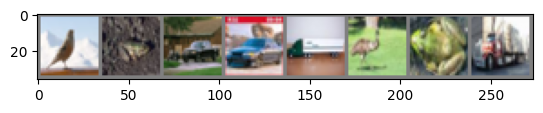

bird  frog  car   car   truck bird  frog  truck


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [36]:
model = Model()

model.to(device)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [38]:
num_epochs = 50

for i in range(num_epochs):
  running_loss = 0.0

  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)

    output = model(images)

    loss = criterion(output, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

print("Training Finished")

Training Finished


In [39]:
correct = 0
total = 0

with torch.no_grad():
    for images,labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 70 %
